## Hierarchical classification using Local Classification per Parent Node technique
Here we use the same approach as in /solutions/custom_tokens/xlm_roberta_with_classification_start_span_token.ipynb to train the first classifier to predict the first class, and we train extra three classifiers for each of those classes that will provide us fine-grained classification.

In [1]:
from pathlib import Path
wd = Path.cwd()
wd = wd.parent.parent
wd = wd / 'merged_data'
sub1 = str(wd) + '/subtask1.parquet'
print(sub1)

/home/matijak/Documents/programiranje/projects/semeval/merged_data/subtask1.parquet


In [2]:
import pandas as pd
df = pd.read_parquet(sub1)
df = df[0:30]

In [3]:
df

,lang,art_name,entity,start,end,class1,classes2,text
0,BG,BG_670.txt,Запад,152,156,Antagonist,"[Conspirator, Instigator, Foreign Adversary]",Опитът на колективния Запад да „обезкърви Руси...
1,BG,BG_670.txt,САЩ,530,532,Antagonist,[Instigator],Опитът на колективния Запад да „обезкърви Руси...
2,BG,BG_670.txt,НАТО,535,538,Antagonist,[Instigator],Опитът на колективния Запад да „обезкърви Руси...
3,BG,BG_670.txt,Украйна,578,584,Antagonist,[Foreign Adversary],Опитът на колективния Запад да „обезкърви Руси...
4,BG,BG_670.txt,украински войници,633,649,Innocent,[Victim],Опитът на колективния Запад да „обезкърви Руси...
5,BG,A9_BG_5871.txt,Москва,327,332,Antagonist,[Terrorist],Зверство! Руснаците започнаха да режат глави н...
6,BG,A9_BG_5190.txt,Киев,447,450,Antagonist,[Terrorist],"Дмитрий Медведев: НПО-та, спонсорирани от Соро..."
7,BG,A9_BG_3182.txt,Молдова,92,98,Innocent,[Exploited],"Западът подготвя за Молдова ролята на ""консума..."
8,BG,A9_BG_3182.txt,НАТО,1085,1088,Antagonist,[Conspirator],"Западът подготвя за Молдова ролята на ""консума..."
9,BG,A9_BG_3182.txt,Запада,1361,1366,Antagonist,[Foreign Adversary],"Западът подготвя за Молдова ролята на ""консума..."


In [4]:
import re
def labelNum(row):
    if row['class1'] == 'Antagonist':
        return int(0)
    if row['class1'] == 'Innocent':
        return int(1)
    if row['class1'] == 'Protagonist':
        return int(2)
def cleanText(row):
    text = str(row['text'])
    #text = re.sub(r'[^\w\s]', ' ', text)
    text = text.replace('\n',' ').replace('  ', ' ')
    return text
df['label1'] = df.apply(labelNum,axis=1)
df['input'] = df.apply(cleanText,axis=1)

In [5]:
df['label1'].dtype

dtype('int64')

In [6]:
def labelNum2(row):
    labels2 = [0 for _ in range(12)]
    if row['label1'] == 2:
        #labels2 = [0 for _ in range(6)]
        if 'Guardian' in row['classes2']:
            labels2[0] = 1
        if 'Martyr' in row['classes2']:
            labels2[1] = 1
        if 'Peacemaker' in row['classes2']:
            labels2[2] = 1
        if 'Rebel' in row['classes2']:
            labels2[3] = 1
        if 'Underdog' in row['classes2']:
            labels2[4] = 1
        if 'Virtuous' in row['classes2']:
            labels2[5] = 1
    elif row['label1'] == 0:
        #labels2 = [0 for _ in range(12)]
        if 'Instigator' in row['classes2']:
           labels2[0] = 1
        if 'Conspirator' in row['classes2']:
            labels2[1] = 1
        if 'Tyrant' in row['classes2']:
            labels2[2] = 1
        if  'Foreign Adversary' in row['classes2']:
            labels2[3] = 1
        if 'Traitor' in row['classes2']:
            labels2[4] = 1
        if 'Spy' in row['classes2']:
            labels2[5] = 1
        if 'Saboteur' in row['classes2']:
            labels2[6] = 1
        if 'Corrupt' in row['classes2']:
            labels2[7] = 1
        if 'Incompetent' in row['classes2']:
            labels2[8] = 1
        if 'Terrorist' in row['classes2']:
            labels2[9] = 1
        if 'Deceiver' in row['classes2']:
            labels2[10] = 1
        if 'Bigot' in row['classes2']:
            labels2[11] = 1
    elif row['label1'] == 1:
        #labels2 = [0 for _ in range(4)]
        if 'Forgotten' in row['classes2']:
            labels2[0] = 1
        if 'Exploited' in row['classes2']:
            labels2[1] = 1
        if 'Victim' in row['classes2']:
            labels2[2] = 1
        if 'Scapegoat' in row['classes2']:
            labels2[3] = 1
    return labels2

df['label2'] = df.apply(labelNum2, axis=1)

In [7]:
def find_all_substring_start_end(text, substring):
    # Use re.finditer to find all occurrences of the substring in the text
    matches = re.finditer(re.escape(substring), text)

    # Collect the start and end indices of all matches
    positions = [(match.start(), match.end()) for match in matches]

    return positions
def adjust_start_end(row):
    org_text,cl_text,start,end,entity = str(row['text']),str(row['input']),int(row['start']),int(row['end']),str(row['entity'])
    ss1 = find_all_substring_start_end(org_text,entity)
    ss2 = find_all_substring_start_end(cl_text,entity)
    #print(ss1,ss2)
    #print(row['text'][start:end])
    a = 0
    for i in range(len(ss1)):
        if abs((ss1[i][0] - start) + (ss1[i][1] - end) ) <= 2:
            a = i
            break
    if org_text[ss1[a][0]:ss1[a][1]] != cl_text[ss2[a][0]:ss2[a][1]]:
        print("ERROR!")
    return ss2[a][0],ss2[a][1]
df['new_start_end'] = df.apply(adjust_start_end,axis=1)
print(df.loc[0])

lang                                                            BG
art_name                                                BG_670.txt
entity                                                       Запад
start                                                          152
end                                                            156
class1                                                  Antagonist
classes2              [Conspirator, Instigator, Foreign Adversary]
text             Опитът на колективния Запад да „обезкърви Руси...
label1                                                           0
input            Опитът на колективния Запад да „обезкърви Руси...
label2                        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
new_start_end                                           (151, 156)
Name: 0, dtype: object


In [8]:
def addTokensToInput(row):
    inp = row['input']
    start,end = row['new_start_end']
    #print(start,end)
    start = int(start)
    end = int(end)
    token_input = inp[:start] + "[SPAN_START] " + inp[start:end] + " [SPAN_END]" + inp[end:]
    return token_input

df['span_input'] = df.apply(addTokensToInput,axis=1)

In [9]:
def upStartEnd(row):
    start,end = row['new_start_end']
    start += len("[SPAN_START] ")
    end += len("[SPAN_START] ")
    return start,end

df['new_start_end'] = df.apply(upStartEnd,axis = 1)

In [10]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3).to(device)
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

def preprocess_function(examples):
    return tokenizer(examples['span_input'], padding=True, truncation=True,max_length=8192,return_offsets_mapping=True)

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
extraTokens = {
    "additional_special_tokens": ["[SPAN_START]", "[SPAN_END]"]
}
num_added_toks = tokenizer.add_special_tokens(extraTokens)
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(250004, 768, padding_idx=1)

In [12]:
data = df.loc[ : , ['span_input', 'label1', 'label2', 'new_start_end', 'entity']]

In [13]:
data

,span_input,label1,label2,new_start_end,entity
0,Опитът на колективния Запад да „обезкърви Руси...,0,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","(164, 169)",Запад
1,Опитът на колективния Запад да „обезкърви Руси...,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","(541, 544)",САЩ
2,Опитът на колективния Запад да „обезкърви Руси...,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","(546, 550)",НАТО
3,Опитът на колективния Запад да „обезкърви Руси...,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","(589, 596)",Украйна
4,Опитът на колективния Запад да „обезкърви Руси...,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","(644, 661)",украински войници
5,Зверство! Руснаците започнаха да режат глави н...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","(339, 345)",Москва
6,"Дмитрий Медведев: НПО-та, спонсорирани от Соро...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","(459, 463)",Киев
7,"Западът подготвя за Молдова ролята на ""консума...",1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","(104, 111)",Молдова
8,"Западът подготвя за Молдова ролята на ""консума...",0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","(1097, 1101)",НАТО
9,"Западът подготвя за Молдова ролята на ""консума...",0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","(1373, 1379)",Запада


In [14]:
data['tokenized']=data.apply(preprocess_function,axis=1)

In [15]:
def indexes(row):
    off_mask = row['tokenized']['offset_mapping']
    start,end = row['new_start_end'][0],row['new_start_end'][1]
    inds = list()
    for p in range(len(off_mask)):
        if off_mask[p][0] >= start and off_mask[p][1] <= end:
            if p != len(off_mask)-1:
                inds.append(p)
    #if len(inds) > 1:
        #print("GREATER THAN 1")
    if len(inds) == 0:
        print(start,end)
    return inds
data['indexes'] = data.apply(indexes,axis=1)

In [16]:
data['list'] = data['tokenized'].apply(lambda x: x['input_ids'])
data['attention'] = data['tokenized'].apply(lambda x: x['attention_mask'])
ids = data['list']
att = data['attention']
indexes = data['indexes']
tids = list()
tatt = list()
print(len(ids),len(att),len(indexes))
for i in range(len(ids)):
    tids.append(torch.tensor(ids[i]))
    tatt.append(torch.tensor(att[i]))

30 30 30


In [17]:
sliced_ids = list()
sliced_ntids = list()
sliced_att = list()
key_inds = list()
key_ids = list()

def slices(index,size,context_size):
    if (size<context_size):
        return 0,size
    lower_c = int(context_size/2-1)
    upper_c = int(context_size/2)
    #print(lower_c,upper_c)
    if index < lower_c:
        return 0,context_size
    elif index >= lower_c:
        if index + upper_c > size:
            return index-(context_size-(size-index)), size
        else:
            return index-lower_c,index+upper_c+1


for i in range(len(tids)):
    slower,supper = slices(indexes[i][0],len(tids[i]),510)
    #key_tid = tids[i][indexes[i][0]]
    pid = ids[i][slower:supper]
    key_inds.append([])
    for j in indexes[i]:
        key_id = ids[i][j]
        if key_id not in pid:
           print(len(ids[i]),key_id,slower,supper,indexes[i])
        key_inds[i].append(pid.index(key_id))
    apid = tids[i][slower:supper]
    apatt = tatt[i][slower:supper]
    if 0 not in pid:
        apid = torch.cat((torch.tensor([0]),apid),dim=0)
        apatt = torch.cat((torch.tensor([1]),apatt),dim=0)
    if 2 not in pid:
        apid = torch.cat((apid,torch.tensor([2])),dim=0)
        apatt = torch.cat((apatt,torch.tensor([1])),dim=0)
    sliced_ids.append(apid)
    sliced_att.append(apatt)

Min = 10000
Max = 0
ind2 = 0
for i in range(len(indexes)):
    if len(sliced_ids[i]) < Min:
        Min = len(sliced_ids[i])
        ind2 = i

    if len(sliced_ids[i]) > Max:
        Max = len(sliced_ids[i])

In [18]:
input_ids = list()
att_mask = list()
for ten,att in zip(sliced_ids,sliced_att):
    if len(ten) < 512:
        padding_length = 512 - len(ten)
        padding_tensor = torch.full((padding_length,), tokenizer.pad_token_id, dtype=ten.dtype)
        padding_tensor2 = torch.full((padding_length,), 0, dtype=att.dtype)
        ten = torch.cat((ten,padding_tensor),dim=0)
        att = torch.cat((att,padding_tensor2),dim=0)
    input_ids.append(ten)
    att_mask.append(att)
inputIds = torch.stack(input_ids)
attMask = torch.stack(att_mask)

inputIds_np = inputIds.numpy()
attMask_np = attMask.numpy()
y1 = data['label1'].values
y2 = data['label2'].values

In [19]:
from sklearn.model_selection import train_test_split
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y1_train, y1_test, y2_train, y2_test = train_test_split(
    inputIds_np, attMask_np, y1, y2, test_size=0.2, random_state=42, shuffle=True
)

In [20]:
import numpy as np
y2_train = np.array(y2_train.tolist(), dtype=np.int8)
y2_test = np.array(y2_test.tolist(), dtype=np.int8)

In [21]:
X_train_ids = torch.tensor(X_train_ids, dtype=torch.long).to(device)
X_test_ids = torch.tensor(X_test_ids, dtype=torch.long).to(device)
X_train_mask = torch.tensor(X_train_mask, dtype=torch.long).to(device)
X_test_mask = torch.tensor(X_test_mask, dtype=torch.long).to(device)
y1_train = torch.tensor(y1_train, dtype=torch.long).to(device)
y1_test = torch.tensor(y1_test, dtype=torch.long).to(device)
y2_train = torch.tensor(y2_train, dtype=torch.long).to(device)
y2_test = torch.tensor(y2_test, dtype=torch.long).to(device)

In [22]:
# Create TensorDatasets
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_ids, X_train_mask, y1_train, y2_train)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y1_test, y2_test )

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn as nn

#first layer classifier
classifier = nn.Linear(model.config.hidden_size, 3).to(device)
#optimizer = AdamW(list(classifier.parameters()) + list(model.parameters()), lr=8e-6)
optimizer = AdamW(classifier.parameters(), lr=8e-6)
criterion = nn.CrossEntropyLoss()

In [24]:
# not used?
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, num_classes=3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()

#criterion = FocalLoss(gamma=2., alpha=0.25)

In [25]:
# second layer classifier model
# class SecondLayerClassifier(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super(SecondLayerClassifier, self).__init__()
#         self.fc = nn.Linear(input_dim, num_classes)

#     def forward(self, x):
#         return torch.sigmoid(self.fc(x))

criterion2 = nn.BCEWithLogitsLoss()

class SecondLayerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout_prob=0.3):
        """
        Multi-layer classifier for second-layer classification.

        Args:
            input_dim (int): Dimension of the input features.
            hidden_dims (list of int): List of hidden layer dimensions.
            num_classes (int): Number of output classes.
            dropout_prob (float): Dropout probability (default: 0.3).
        """
        super(SecondLayerClassifier, self).__init__()

        self.num_classes = num_classes

        layers = []
        current_dim = input_dim

        # Add hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_prob)) #probably dont need drouput, since we use dropout for final probability, try to remove this
            current_dim = hidden_dim

        # Final output layer
        layers.append(nn.Linear(current_dim, num_classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [26]:
#klasifikatori za finiju granulaciju

hidden_dimension = [768, 512]

child_classifiers = {
    int(0) : SecondLayerClassifier(input_dim=model.config.hidden_size, hidden_dims=hidden_dimension, num_classes=12).to(device) , #Antagonist
    int(1) : SecondLayerClassifier(input_dim=model.config.hidden_size, hidden_dims=hidden_dimension, num_classes=4).to(device) , #Innocent
    int(2) : SecondLayerClassifier(input_dim=model.config.hidden_size, hidden_dims=hidden_dimension,  num_classes=6).to(device) , #Protagonist
}

second_layer_optimizers = {
    name: AdamW(child.parameters(), lr=0.0001)
    for name, child in child_classifiers.items()
}

In [27]:
for cls, child_classifier in child_classifiers.items():
  print(cls)
  print(child_classifier)

0
SecondLayerClassifier(
  (model): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=768, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=12, bias=True)
  )
)
1
SecondLayerClassifier(
  (model): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=768, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=4, bias=True)
  )
)
2
SecondLayerClassifier(
  (model): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=768, out_features=51

In [28]:
import numpy as np
# for the confusion matrix in the end
all_preds = np.array([], dtype=np.int8)
all_labels = np.array([], dtype=np.int8)

TODO:
Ovdje treba dodati da nakon sto uzmemo entity_representations na temelju koje smo do sada odredjivali prvu klasu, da ih damo i drugim klasifikatorima, ali tijekom treniranja treba iskoristiti cinjenicu da znamo tocnu prvu klasu, dakle iz odluciti na temelju pravog label-a kojem klasifikatoru dajemo podatke.
Testiranje u zadnjoj epohi se provodi tako da nakon sto je nas model odredio prvu klasu, prosljedujemo taj input klasifikatoru nize razine.

NE RADI, pitanje moze li se uopce paralelno trenirati ta 4 klasifikatora... stalno baca errore u okviru treniranja druge klasifikacije

In [29]:
torch.autograd.set_detect_anomaly(True)
#retain_graph je potencijalno nepotreban

num_epochs = 6
debug = 0
for epoch in range(num_epochs):

    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    second_layer_stats = {
        cls: {'loss': 0.0, 'correct': 0, 'total': 0}
        for cls in child_classifiers.keys()
    }

    train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

    for batch in train_progress_bar:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels_1 = batch[2].to(device)
        labels_2 = batch[3].to(device)  # second-layer labels

        batch_size = input_ids.size(0)

        #taking the output from BERT model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_1, output_hidden_states=True)

        hidden_states = outputs.hidden_states[-1]

        span_start_token_id = tokenizer.convert_tokens_to_ids('[SPAN_START]')
        #span_end_token_id = tokenizer.convert_tokens_to_ids('[SPAN_END]')

        start_mask = (input_ids == span_start_token_id)
        #end_mask = (input_ids == span_end_token_id)

        entity_representations = []

        start_indices = start_mask.nonzero(as_tuple=True)[1]
        #end_indices = end_mask.nonzero(as_tuple=True)[1]

        valid_spans = (start_indices != -1) #& (end_indices != -1) & (start_indices <= end_indices)

        valid_start_indices = start_indices[valid_spans]
        #valid_end_indices = end_indices[valid_spans]

        for i in range(batch_size):
            entity_tokens = hidden_states[i, valid_start_indices[i]] #for this version only start span tokens
            entity_representations.append(entity_tokens)

        entity_representations = torch.stack(entity_representations, dim=0)

        #first layer classification
        logits = classifier(entity_representations)
        loss = criterion(logits, labels_1)

        loss.backward(retain_graph=True)
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        correct_predictions += (preds == labels_1).sum().item()
        total_predictions += labels_1.size(0)

        train_progress_bar.set_postfix({'loss': loss.item()})

        #second layer classification

        for cls, second_layer_classifier in child_classifiers.items():
            second_layer_indices = (labels_1 == cls).nonzero(as_tuple=True)[0]

            if second_layer_indices.size(0) > 0:
                second_layer_inputs = entity_representations[second_layer_indices]

                num_classes = second_layer_classifier.num_classes
                second_layer_labels = labels_2[second_layer_indices, :num_classes].float()

                child_logits = second_layer_classifier(second_layer_inputs)
                child_loss = criterion2(child_logits, second_layer_labels)

                second_layer_optimizers[cls].zero_grad()
                child_loss.backward(retain_graph=True)
                second_layer_optimizers[cls].step()

                #TODO change this, it only counts as correct if all the labels are correcty predicted for one input
                second_layer_stats[cls]['loss'] += child_loss.item() * second_layer_labels.size(0)
                child_preds = (torch.sigmoid(child_logits) > 0.29).int() #TODO find perfect threshold
                correct = (child_preds == second_layer_labels.int()).sum().item()
                second_layer_stats[cls]['correct'] += correct
                second_layer_stats[cls]['total'] += second_layer_labels.numel()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")

    for cls, stats in second_layer_stats.items():
        if stats['total'] > 0:
            avg_loss = stats['loss'] / stats['total']
            accuracy = stats['correct'] / stats['total']
        else:
            avg_loss = 0.0
            accuracy = 0.0
        print(f"Second-Layer Classifier: {cls}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

#TO DO uncomment and add second layer classification for the evaluation

    # model.eval()
    # test_loss = 0
    # correct_test_predictions = 0
    # total_test_predictions = 0

    # test_progress_bar = tqdm(test_dataloader, desc=f"Test Epoch {epoch + 1}/{num_epochs}")

    # with torch.no_grad():
    #     for batch in test_progress_bar:

    #         input_ids = batch[0].to(device)
    #         attention_mask = batch[1].to(device)
    #         labels = batch[2].to(device)

    #         batch_size = input_ids.size(0)

    #         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)

    #         hidden_states = outputs.hidden_states[-1]

    #         span_start_token_id = tokenizer.convert_tokens_to_ids('[SPAN_START]')
    #         span_end_token_id = tokenizer.convert_tokens_to_ids('[SPAN_END]')

    #         start_mask = (input_ids == span_start_token_id)
    #         end_mask = (input_ids == span_end_token_id)

    #         entity_representations = []

    #         start_indices = start_mask.nonzero(as_tuple=True)[1]
    #         end_indices = end_mask.nonzero(as_tuple=True)[1]

    #         valid_spans = (start_indices != -1) & (end_indices != -1) & (start_indices <= end_indices)

    #         valid_start_indices = start_indices[valid_spans]
    #         valid_end_indices = end_indices[valid_spans]

    #         # extract entity tokens for every sample in batch
    #         for i in range(batch_size):
    #             entity_tokens = hidden_states[i, valid_start_indices[i]]
    #             entity_representations.append(entity_tokens)

    #         entity_representations = torch.stack(entity_representations, dim=0)

    #         logits = classifier(entity_representations)
    #         loss = criterion(logits, labels)
    #         test_loss += loss.item()

    #         #if epoch is the last epoch we want to redirect data to second layer classifier according to predicted label

    #         preds = torch.argmax(logits, dim=-1)
    #         if epoch == num_epochs-1:
    #             all_preds = np.concatenate((all_preds, preds.cpu().numpy()))
    #             all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

    #         correct_test_predictions += (preds == labels).sum().item()
    #         total_test_predictions += labels.size(0)

    #         test_progress_bar.set_postfix({'loss': loss.item()})

    # avg_test_loss = test_loss / len(test_dataloader)
    # test_accuracy = correct_test_predictions / total_test_predictions

    # print(f"Test loss: {avg_test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Training Epoch 1/6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it, loss=1.18]


Epoch 1/6
Training loss: 1.1822, Training accuracy: 0.2917
Second-Layer Classifier: 0, Avg Loss: 0.0764, Accuracy: 0.1071
Second-Layer Classifier: 1, Avg Loss: 0.2118, Accuracy: 0.2500
Second-Layer Classifier: 2, Avg Loss: 0.1461, Accuracy: 0.2000


Training Epoch 2/6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it, loss=1.21]


Epoch 2/6
Training loss: 1.1918, Training accuracy: 0.2500
Second-Layer Classifier: 0, Avg Loss: 0.0759, Accuracy: 0.1071
Second-Layer Classifier: 1, Avg Loss: 0.2104, Accuracy: 0.2500
Second-Layer Classifier: 2, Avg Loss: 0.1448, Accuracy: 0.2000


Training Epoch 3/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it, loss=1.2]


Epoch 3/6
Training loss: 1.1877, Training accuracy: 0.2500
Second-Layer Classifier: 0, Avg Loss: 0.0754, Accuracy: 0.1071
Second-Layer Classifier: 1, Avg Loss: 0.2085, Accuracy: 0.2500
Second-Layer Classifier: 2, Avg Loss: 0.1438, Accuracy: 0.2000


Training Epoch 4/6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it, loss=1.2]


Epoch 4/6
Training loss: 1.1889, Training accuracy: 0.2917
Second-Layer Classifier: 0, Avg Loss: 0.0749, Accuracy: 0.1071
Second-Layer Classifier: 1, Avg Loss: 0.2067, Accuracy: 0.2500
Second-Layer Classifier: 2, Avg Loss: 0.1429, Accuracy: 0.2000


Training Epoch 5/6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it, loss=1.02]


Epoch 5/6
Training loss: 1.1297, Training accuracy: 0.2500
Second-Layer Classifier: 0, Avg Loss: 0.0745, Accuracy: 0.1071
Second-Layer Classifier: 1, Avg Loss: 0.2056, Accuracy: 0.2500
Second-Layer Classifier: 2, Avg Loss: 0.1415, Accuracy: 0.2000


Training Epoch 6/6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it, loss=1.17]

Epoch 6/6
Training loss: 1.1361, Training accuracy: 0.3750
Second-Layer Classifier: 0, Avg Loss: 0.0740, Accuracy: 0.1071
Second-Layer Classifier: 1, Avg Loss: 0.2032, Accuracy: 0.2500
Second-Layer Classifier: 2, Avg Loss: 0.1411, Accuracy: 0.2000


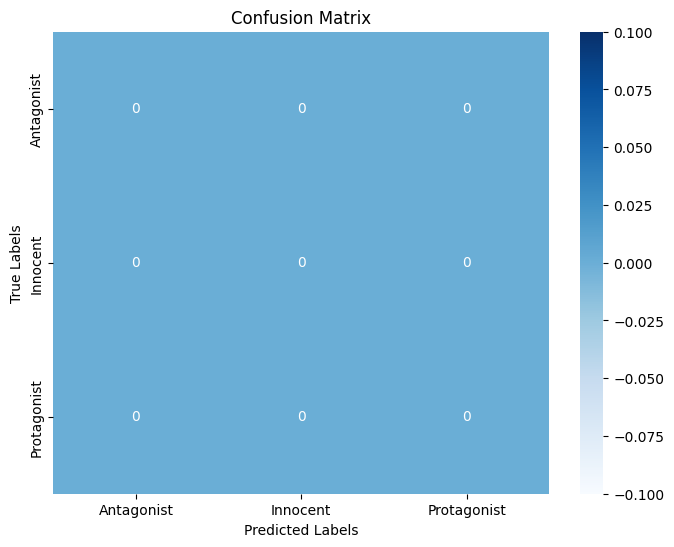

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Comments for the future work
- around 20% of predictions for the class 'innocent' is false predicted - this is very expected in the sentiment classification and polarity problems, that a neutral label will be harder to predict
- around 16.9% of predictions for the class 'protagonist' is false predicted
- around 15.7% of predictions for the class 'antagonist' is false predicted (note that 'antagonist' has significantly more representations in our dataset than 'innocent' and 'protagonist,' which could easily introduce bias into our model)

- many false predictions are coming from the "opposite" classes, which could be easily influenced by models' bad generalization and tendency to memorize articles that are having the same 2 topics, for example in the non-Russian articles, Russia could be a Antagonist, and Russian articles are probably naming themself a innocent or protagonist (should be explored directly when evaluating the model)